### Exercise 7.04 : Building the GAN network

In [1]:
# Import the required library functions
import tensorflow as tf
import numpy as np
from numpy.random import randn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot

In [2]:
# Function to generate real samples
def realData(loc,batch):
    # loc is the random location or mean around which samples are centred
    # Generate numbers to right of the random point
    xr = np.arange(loc,loc+(0.1*batch/2),0.1)
    xr = xr[0:int(batch/2)]
    # Generate numbers to left of the random point
    xl = np.arange(loc-(0.1*batch/2),loc,0.1)
    # Concatenating both these series 
    X1 = np.concatenate((xl,xr))
    # Second dependent variable
    X2 = np.sin(X1)
    # Reshaping both the variables and then concatenating them to an array of independent variables
    X1 = X1.reshape(batch,1)
    X2 = X2.reshape(batch,1)    
    X = np.concatenate((X1,X2),axis = 1)
    # Generating the labels for real data set which is 'ones'
    y = np.ones((batch,1))    
    return X,y

In [3]:
# Function to generate inputs for generator function
def fakeInputs(batch,infeats):
    # Sample data points equal to (batch x input feature size) from a random distribution
    genInput = randn(infeats * batch)
    # Reshape the input
    X = genInput.reshape(batch ,infeats)
    return X



In [4]:
# Function for the generator model
def genModel(infeats,outfeats):
    # Defining the Generator model
    Genmodel = Sequential()
    Genmodel.add(Dense(32,activation = 'linear',kernel_initializer='he_uniform',input_dim=infeats))
    Genmodel.add(Dense(32,activation = 'relu',kernel_initializer='he_uniform'))    
    Genmodel.add(Dense(64,activation = 'elu',kernel_initializer='he_uniform'))    
    Genmodel.add(Dense(32,activation = 'elu',kernel_initializer='he_uniform'))    
    Genmodel.add(Dense(32,activation = 'selu',kernel_initializer='he_uniform'))
    Genmodel.add(Dense(outfeats,activation = 'selu'))
    return Genmodel

In [5]:
# Function to create fake samples using the generator model
def fakedataGenerator(Genmodel,batch,infeats):
    # first generate the inputs to the model
    genInputs = fakeInputs(batch,infeats)
    # use these inputs inside the generator model to generate fake distribution
    X_fake = Genmodel.predict(genInputs)
    # Generate the labels of fake data set
    y_fake = np.zeros((batch,1))
    
    return X_fake,y_fake

In [6]:
# Define the arguments like batch size,input feature size and output feature size
batch = 128
infeats = 10
outfeats = 2

Next we develop the discriminator model which is a network having 4 layers

In [7]:
# Descriminator model as a function
def discModel(outfeats):
    Discmodel = Sequential()
    Discmodel.add(Dense(16, activation='relu',kernel_initializer = 'he_uniform',input_dim=outfeats))
    Discmodel.add(Dense(16,activation='relu' ,kernel_initializer = 'he_uniform'))
    Discmodel.add(Dense(16,activation='relu' ,kernel_initializer = 'he_uniform'))    
    Discmodel.add(Dense(1,activation='sigmoid'))
    # Compiling the model
    Discmodel.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])    
    return Discmodel 

In [8]:
# Print the summary of the discriminator model
Discmodel = discModel(outfeats)
Discmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Calling the Generator model function
Genmodel = genModel(infeats,outfeats)
Genmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
Total params: 6,722
Trainable params: 6,722
Non-trainable params: 0
____________________________________________________

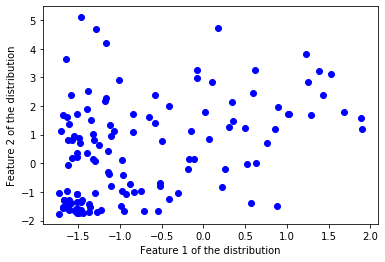

In [10]:
# Let us visualize the initial fake data
x_fake, _ = fakedataGenerator(Genmodel,batch,infeats)
# Plotting the fake data using pyplot
pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
# Adding x and y labels
pyplot.xlabel('Feature 1 of the distribution')
pyplot.ylabel('Feature 2 of the distribution')
pyplot.show()


In [11]:
# Define the combined generator and discriminator model, for updating the generator
def ganModel(Genmodel,Discmodel):
    # First define that discriminator model cannot be trained
    Discmodel.trainable = False
    Ganmodel = Sequential()
    # First adding the generator model
    Ganmodel.add(Genmodel)
    # Next adding the discriminator model without training the parameters
    Ganmodel.add(Discmodel)
    # Compile the model for loss to optimise the Generator model
    Ganmodel.compile(loss='binary_crossentropy',optimizer = 'adam')    
    return Ganmodel

In [12]:
# Initialise the gan model
gan_model = ganModel(Genmodel,Discmodel)

In [13]:
# Print summary of the GAN model
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 2)                 6722      
_________________________________________________________________
sequential (Sequential)      (None, 1)                 609       
Total params: 7,331
Trainable params: 6,722
Non-trainable params: 609
_________________________________________________________________


In [14]:
# Defining the number of epochs
nEpochs = 20000

In [15]:
# Train the GAN network
for i in range(nEpochs):
    # Generate the random number for generating real samples
    loc = np.random.normal(3,1,1)
    # Generate samples equal to the bath size from the real distribution
    x_real, y_real = realData(loc,batch)
    # Generate fake samples using the fake data generator function
    x_fake, y_fake = fakedataGenerator(Genmodel,batch,infeats)
    # train the  discriminator on the real samples
    Discmodel.train_on_batch(x_real, y_real)
    # train the discriminator on the fake samples
    Discmodel.train_on_batch(x_fake, y_fake)
    # Generate new fake inputs for training the GAN network
    x_gan = fakeInputs(batch,infeats)
    # Create labels of the fake examples as 1 to fool the discriminator
    y_gan = np.ones((batch, 1))
    # Update the generator model through the discriminator model
    gan_model.train_on_batch(x_gan, y_gan)
    # Print the accuracy measures on the real and fake data for every 2000 epochs
    if (i) % 2000 == 0:
        # Generate samples equal to the bath size from the real distribution
        x_real, y_real = realData(loc,batch)
        # Evaluate Real distribution accuracy
        _, realAccuracy = Discmodel.evaluate(x_real, y_real, verbose=0)
        # Generate fake samples using the fake data generator function
        x_fake,y_fake = fakedataGenerator(Genmodel,batch,infeats)
        # Evaluate fake distribution accuracy levels
        _, fakeAccuracy = Discmodel.evaluate(x_fake, y_fake, verbose=0)
        print('Real accuracy:{R},Fake accuracy:{F}'.format(R=realAccuracy,F=fakeAccuracy))
        # scatter plot real and fake data points
        pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
        pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
        pyplot.xlabel('Feature 1 of the distribution')
        pyplot.ylabel('Feature 2 of the distribution')
        # save plot to file
        filename = 'GAN_Training_Plot%03d.png' % (i)
        pyplot.close()

Real accuracy:1.0,Fake accuracy:0.015625
Real accuracy:0.4609375,Fake accuracy:0.875
Real accuracy:0.46875,Fake accuracy:0.8828125
Real accuracy:0.4140625,Fake accuracy:0.484375
Real accuracy:0.2265625,Fake accuracy:1.0
Real accuracy:0.1796875,Fake accuracy:0.9765625
Real accuracy:0.3046875,Fake accuracy:0.90625
Real accuracy:0.140625,Fake accuracy:0.9375
Real accuracy:0.4296875,Fake accuracy:0.84375
Real accuracy:0.4375,Fake accuracy:0.7734375
